# HOT Region Visualization

### The following section rebuilds the kmer data to use for visualization. Visualization starts at code cell [8].

The following cell defines file names and parameters.

- **kmer_length** denotes the number of basepairs considered when converting sequences to kmers
- **sampling_percentage** denotes the percentage of sequences that will be used to build the model
- **seed** is for reproducing results

In [1]:
input_hot = 'hot_regions_01_all.fa'
input_lot = 'lot_regions_01_all.fa'
kmer_length = 5
sampling_percentage = 1
seed = 35

The following cell includes all imports used in this notebook.

In [2]:
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from Bio.SeqIO.FastaIO import SimpleFastaParser
from sklearn.utils import resample
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import normalize, MaxAbsScaler
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

The following cell parses the input Fasta files for HOT and LOT sequences and builds lists of the sequences.

In [3]:
with open(input_hot) as fasta_file:
    hot_sequences = []
    for title, sequence in SimpleFastaParser(fasta_file):
        hot_sequences.append(sequence)

with open(input_lot) as fasta_file:
    lot_sequences = []
    for title, sequence in SimpleFastaParser(fasta_file):
        lot_sequences.append(sequence)

The following cell creates dataframes for the HOT and LOT sequences with the following labels:
- *1* for HOT sequences (positive class)
- *0* for LOT sequences (negative class)

In [4]:
df_hot = pd.DataFrame(hot_sequences, columns=['sequence'])
df_hot['label'] = 1

df_lot = pd.DataFrame(lot_sequences, columns=['sequence'])
df_lot['label'] = 0

The following cell performs downsampling on the majority class using **seed** and aggregates the sequences inside *df_resample*.

In [5]:
if df_hot.shape[0] < df_lot.shape[0]:
    df_minority = df_hot.sample(n=int(df_hot.shape[0]*sampling_percentage), random_state=seed)
    df_majority = df_lot.sample(n=int(df_lot.shape[0]*sampling_percentage), random_state=seed)
else:
    df_majority = df_hot.sample(n=int(df_hot.shape[0]*sampling_percentage), random_state=seed)
    df_minority = df_lot.sample(n=int(df_lot.shape[0]*sampling_percentage), random_state=seed)

df_majority_downsampled = resample(df_majority, replace=False, n_samples=df_minority.shape[0], random_state=seed)

df_resample = pd.concat([df_majority_downsampled, df_minority])

The following cell defines a helper function that returns the extracted kmers from the sequences. Next, it replaces the HOT/LOT sequences by their extracted kmers (list format). Finally it converts each list of kmers into sentences to be fed into CountVectorizer.

In [6]:
def kmers(seq, length):
    return [seq[i:i+length].lower() for i in range(len(seq)-length+1)]

df_resample['kmers'] = df_resample.apply(lambda a: kmers(a['sequence'], kmer_length), axis=1)
df_resample.drop('sequence',axis=1, inplace=True)
df_resample = df_resample.reset_index()
df_resample.drop('index', axis=1, inplace=True)

kmer_sentences = list(df_resample['kmers'])
for x in range(len(kmer_sentences)):
    kmer_sentences[x] = ' '.join(kmer_sentences[x])

labels = df_resample.iloc[:,0].values

The following cell counts kmer occurences in the sentences using CountVectorizer and performs Min-Max normalization on the vectors. 

In [7]:
c = CountVectorizer(ngram_range=(1,1))
x = c.fit_transform(kmer_sentences)

x_normalized = normalize(x, norm='l1')
scaler = MaxAbsScaler()
x_scaled = scaler.fit_transform(x_normalized)
scaled_df_unsorted = pd.DataFrame(x_scaled.toarray(), columns=c.vocabulary_)
scaled_df = scaled_df_unsorted.reindex(sorted(scaled_df_unsorted.columns), axis=1)

The following cell performs 2D TSNE on our normalized kmer distributions.

In [12]:
time_start = time.time()
tsne = TSNE(n_components=2, perplexity=100, n_iter=1000, learning_rate='auto', init='random')
tsne_results = tsne.fit_transform(x_scaled)
print('t-SNE done! Time elapsed: {} seconds'.format(round(time.time()-time_start,2)))

t-SNE done! Time elapsed: 15.7 seconds


The following cell outputs the results of the previous cell with rescaled axes to ignore outliers.

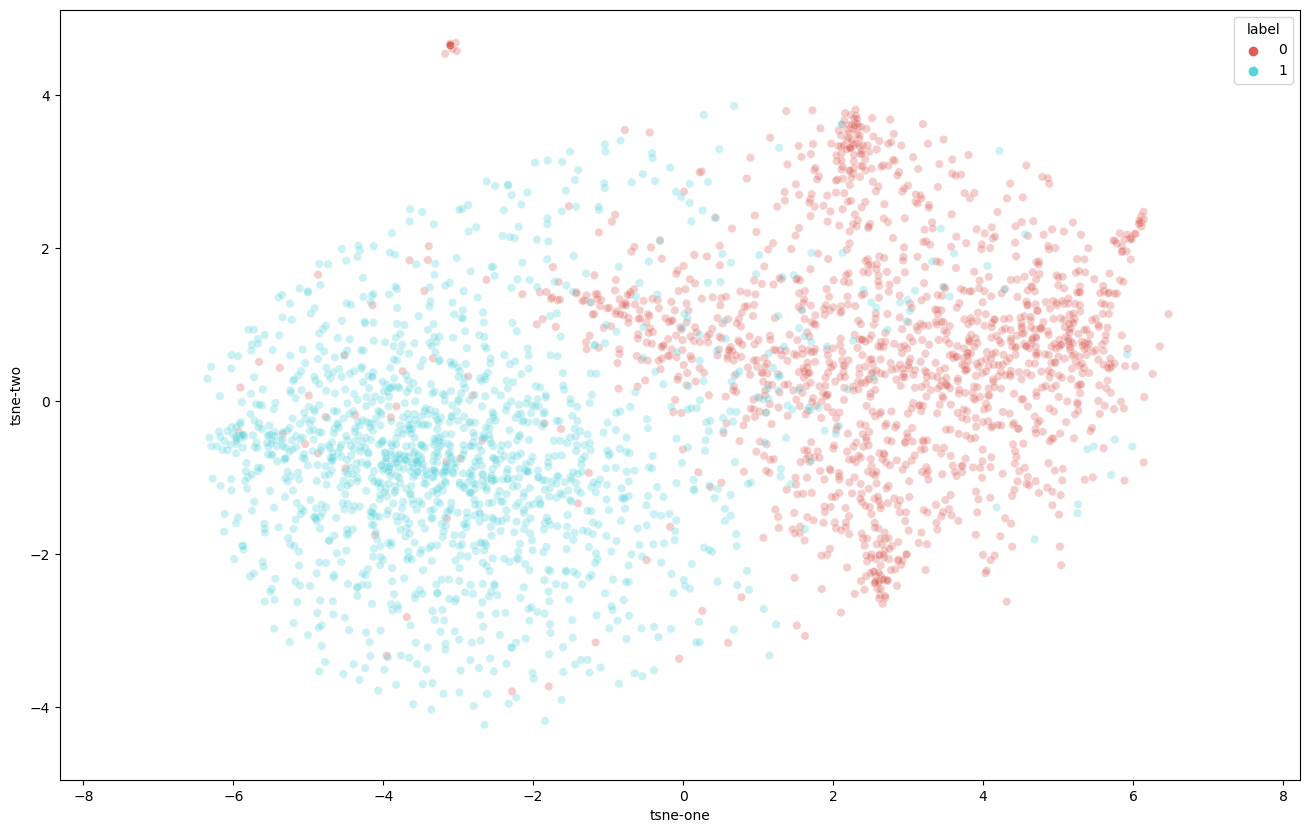

In [9]:
df_resample['tsne-one'] = tsne_results[:,0]
df_resample['tsne-two'] = tsne_results[:,1]

# Rescaling x axis
xpbot = np.percentile(df_resample['tsne-one'],1)
xptop = np.percentile(df_resample['tsne-one'],99)
xpad = 0.2*(xptop-xpbot)
xmin = xpbot - xpad
xmax = xptop + xpad

# Rescaling y axis
ypbot = np.percentile(df_resample['tsne-two'],1)
yptop = np.percentile(df_resample['tsne-two'],99)
ypad = 0.2*(yptop-ypbot)
ymin = ypbot - ypad
ymax = yptop + ypad

fig = plt.figure(figsize=(16,10))
ax = sns.scatterplot(
    x="tsne-one", y="tsne-two",
    hue="label",
    palette=sns.color_palette("hls", 2),
    data=df_resample,
    legend="full",
    alpha=0.3
)
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])
plt.show()

The following cell performs 3D TSNE on our normalized kmer distributions.

In [10]:
time_start = time.time()
tsne = TSNE(n_components=3, perplexity=100, n_iter=1000, learning_rate='auto', init='random')
tsne_results = tsne.fit_transform(x_scaled)
print('t-SNE done! Time elapsed: {} seconds'.format(round(time.time()-time_start,2)))

t-SNE done! Time elapsed: 29.57 seconds


The following cell outputs the results of the previous cell with rescaled axes to ignore outliers.

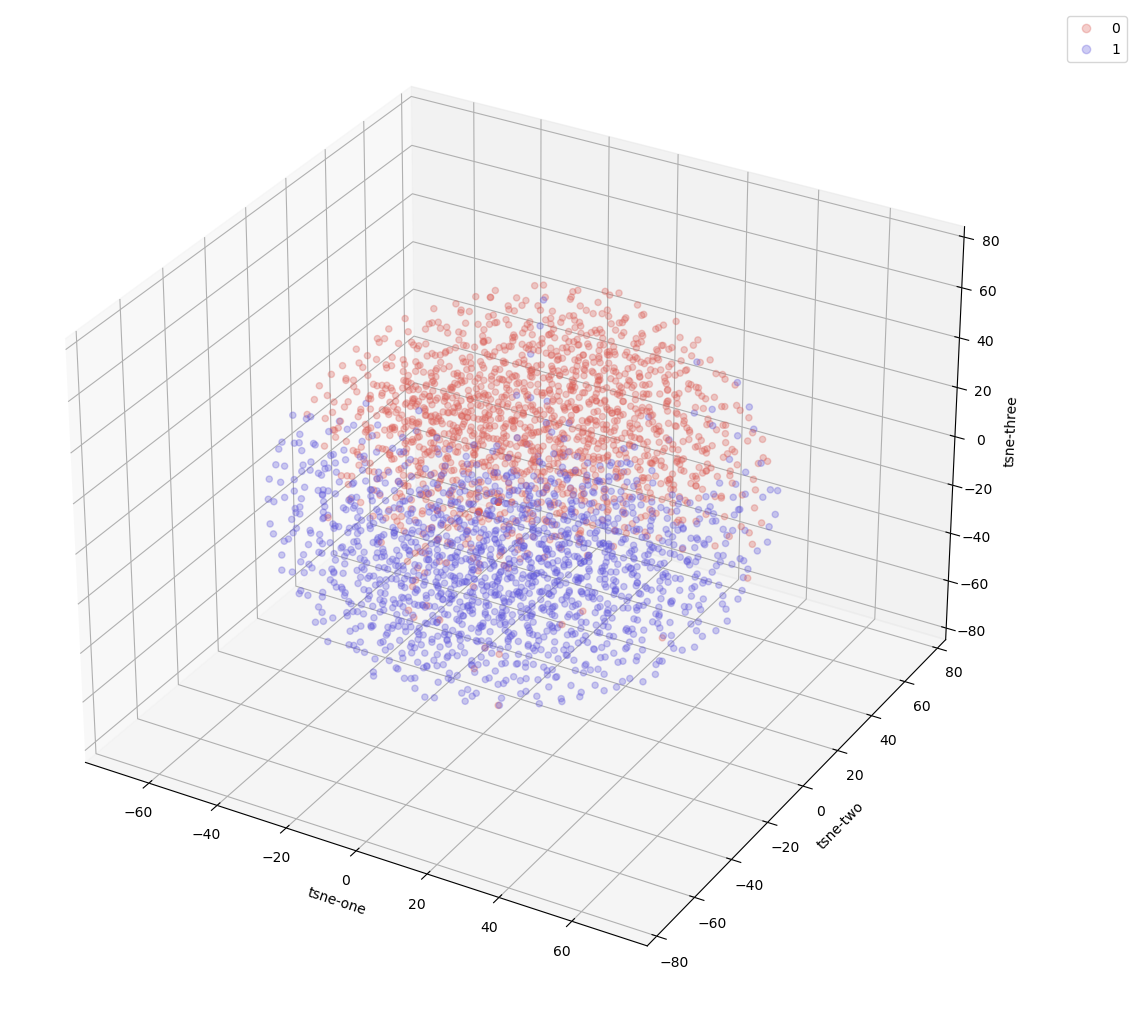

In [11]:
df_resample['tsne-one'] = tsne_results[:,0]
df_resample['tsne-two'] = tsne_results[:,1]
df_resample['tsne-three'] = tsne_results[:,2]

# Rescaling x axis
xpbot = np.percentile(df_resample['tsne-one'],1)
xptop = np.percentile(df_resample['tsne-one'],99)
xpad = 0.2*(xptop-xpbot)
xmin = xpbot - xpad
xmax = xptop + xpad

# Rescaling y axis
ypbot = np.percentile(df_resample['tsne-two'],1)
yptop = np.percentile(df_resample['tsne-two'],99)
ypad = 0.2*(yptop-ypbot)
ymin = ypbot - ypad
ymax = yptop + ypad

# Rescaling z axis
zpbot = np.percentile(df_resample['tsne-three'],1)
zptop = np.percentile(df_resample['tsne-three'],99)
zpad = 0.2*(zptop-zpbot)
zmin = zpbot - zpad
zmax = zptop + zpad

# Initializing axes
fig = plt.figure(figsize=(16,10))
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)

# Getting colormap from seaborn
cmap = ListedColormap(sns.color_palette("hls", 3).as_hex())

# Plotting scatterplot
sc = ax.scatter(df_resample['tsne-one'],
                df_resample['tsne-two'],
                df_resample['tsne-three'],
                c=df_resample['label'], cmap=cmap, alpha=0.3)
ax.set_xlabel('tsne-one')
ax.set_ylabel('tsne-two')
ax.set_zlabel('tsne-three')
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])
ax.set_zlim([zmin, zmax])
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)

plt.show()